In [1]:
import numpy as np
import pandas as pd

In [139]:
df = pd.read_csv('/Users/user/Desktop/iot_project/data/aqi_data_guwahati_1year.csv')

In [140]:
df

,Unnamed: 0,station,date,avg_aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,0,"Railway Colony, Guwahati - APCB",2024-03-26,2.750000,791.350417,0.167083,10.065833,41.121667,5.074583,31.688333,37.015000,5.262083
1,1,"Railway Colony, Guwahati - APCB",2024-03-27,2.708333,712.911250,0.197917,8.905833,54.077500,3.794167,27.022917,33.687917,6.773750
2,2,"Railway Colony, Guwahati - APCB",2024-03-28,3.166667,786.343750,0.368750,11.260000,55.360417,3.942917,38.570000,50.443333,8.093333
3,3,"Railway Colony, Guwahati - APCB",2024-03-29,3.416667,852.544583,0.673750,13.125000,56.034583,6.035833,48.877917,60.827917,10.180000
4,4,"Railway Colony, Guwahati - APCB",2024-03-30,3.291667,774.660833,0.547917,13.096667,54.070833,5.022083,44.456667,54.043333,8.880417
...,...,...,...,...,...,...,...,...,...,...,...,...
2191,2191,"LGBI Airport, Guwahati - PCBA",2025-03-22,4.416667,1003.305833,0.013333,12.472500,47.147917,5.691667,77.963333,84.628750,12.242917
2192,2192,"LGBI Airport, Guwahati - PCBA",2025-03-23,3.833333,989.953333,0.119167,14.012917,60.484583,6.124583,55.885000,63.492917,15.166250
2193,2193,"LGBI Airport, Guwahati - PCBA",2025-03-24,3.791667,973.821250,0.237083,10.678750,73.247083,2.987917,52.161667,64.577500,11.904167
2194,2194,"LGBI Airport, Guwahati - PCBA",2025-03-25,4.000000,812.490833,0.146250,5.970833,86.814583,3.581250,58.603333,73.698750,15.728333


In [141]:
def create_sequences(df, pollutants, window_size=7):
    """
    Build sliding windows of length 'window_size' for each station,
    returning X, y for multi-output regression.
    
    X will have shape: (num_samples, window_size * num_features)
    y will have shape: (num_samples, num_features)
    """
    X_list = []
    Y_list = []
    
    # Group by station so we don't mix sequences across stations
    for st, group in df.groupby("station"):
        # Sort by date to ensure chronological order
        group = group.sort_values("date").reset_index(drop=True)
        
        # Drop rows with NaN in any of the pollutant columns
        group = group.dropna(subset=pollutants)
        
        # If not enough rows for a 7-day window + next day
        if len(group) <= window_size:
            continue
        
        # Extract just the pollutant columns as a NumPy array
        # Shape: (num_days_for_station, num_pollutants)
        arr = group[pollutants].values
        
        # Slide over the array to create 7-day inputs -> next-day target
        for i in range(len(arr) - window_size):
            # 7-day window of shape (7, num_pollutants) -> flatten into 1D
            X_window = arr[i : i + window_size].flatten()
            # The day after the window is the target
            Y_target = arr[i + window_size]
            
            X_list.append(X_window)
            Y_list.append(Y_target)
    
    X = np.array(X_list)
    y = np.array(Y_list)
    return X, y

In [143]:
df1 = df.sort_values(["station", "date"]).reset_index(drop=True)

# Define the columns you want to predict (multi-output)
pollutants = ["avg_aqi", "co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]

# Build the sequences
X, y = create_sequences(df, pollutants=pollutants, window_size=7)
print("X shape:", X.shape)  
print("y shape:", y.shape)

X shape: (2162, 63)
y shape: (2162, 9)


In [144]:
X[0]

array([2.75000000e+00, 7.91350417e+02, 1.67083333e-01, 1.00658333e+01,
       4.11216667e+01, 5.07458333e+00, 3.16883333e+01, 3.70150000e+01,
       5.26208333e+00, 2.75000000e+00, 7.91350417e+02, 1.67083333e-01,
       1.00658333e+01, 4.11216667e+01, 5.07458333e+00, 3.16883333e+01,
       3.70150000e+01, 5.26208333e+00, 2.70833333e+00, 7.12911250e+02,
       1.97916667e-01, 8.90583333e+00, 5.40775000e+01, 3.79416667e+00,
       2.70229167e+01, 3.36879167e+01, 6.77375000e+00, 2.70833333e+00,
       7.12911250e+02, 1.97916667e-01, 8.90583333e+00, 5.40775000e+01,
       3.79416667e+00, 2.70229167e+01, 3.36879167e+01, 6.77375000e+00,
       3.16666667e+00, 7.86343750e+02, 3.68750000e-01, 1.12600000e+01,
       5.53604167e+01, 3.94291667e+00, 3.85700000e+01, 5.04433333e+01,
       8.09333333e+00, 3.16666667e+00, 7.86343750e+02, 3.68750000e-01,
       1.12600000e+01, 5.53604167e+01, 3.94291667e+00, 3.85700000e+01,
       5.04433333e+01, 8.09333333e+00, 3.41666667e+00, 8.52544583e+02,
      

In [145]:
y[0]

array([3.41666667e+00, 8.52544583e+02, 6.73750000e-01, 1.31250000e+01,
       5.60345833e+01, 6.03583333e+00, 4.88779167e+01, 6.08279167e+01,
       1.01800000e+01])

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(63,)),
    Dense(64, activation='relu'),
    Dense(9)  # Linear output layer for multi-output regression
])
print("Scaler fitted on shape:", scaler.mean_.shape)




Scaler fitted on shape: (63,)


/Users/user/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67147.9766 - mae: 101.1054 - val_loss: 70312.5625 - val_mae: 102.7569
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 47004.4023 - mae: 80.1798 - val_loss: 21291.2129 - val_mae: 51.5359
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 15850.6006 - mae: 44.0486 - val_loss: 16214.1797 - val_mae: 44.9944
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 12665.1484 - mae: 38.7627 - val_loss: 13915.0654 - val_mae: 41.2974
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - loss: 11198.7627 - mae: 35.7774 - val_loss: 11787.5928 - val_mae: 37.6397
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - loss: 9115.5713 - mae: 32.2220 - val_loss: 9873.5000 - val_mae: 35.1448
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 8256.9697 - mae: 30.9816 - val_loss: 8377.5449 - val_mae: 32.2821
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 7145.8218 - mae: 28.8502 - val_loss: 702

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
Train R^2: 0.981
Test R^2:  0.986


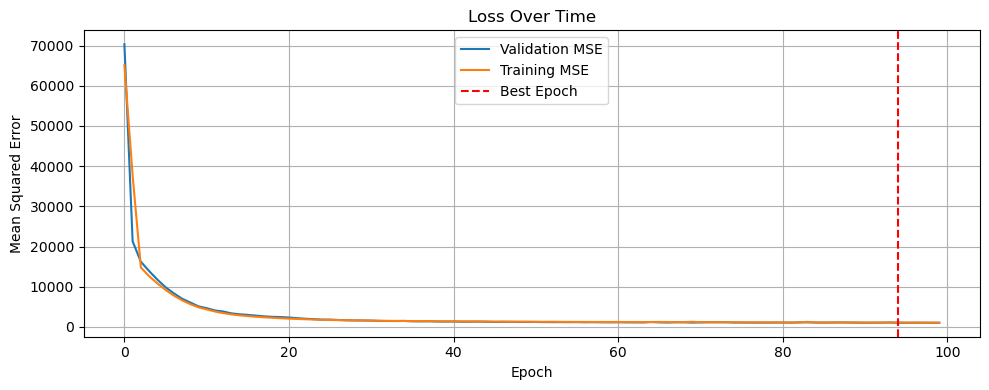

In [147]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
from tensorflow.keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(
    "/Users/user/Desktop/iot_project/models/aqi_best_model.keras",
    save_best_only=True
)

# Train model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, model_ckpt],
    verbose=1
)

# Load best model
model = load_model("/Users/user/Desktop/iot_project/models/aqi_best_model.keras")
import joblib
joblib.dump(scaler, "/Users/user/Desktop/iot_project/models/aqi_scaler.pkl")


# Evaluation
train_loss, train_mae = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nBest Test MSE: {test_loss:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE:  {test_mae:.4f}")

# Predict
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Manual R^2 computation (optional, for comparison)
train_r2 = 1 - np.sum((y_train - y_train_pred) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)
test_r2 = 1 - np.sum((y_test - y_test_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)

print(f"Train R^2: {train_r2:.3f}")
print(f"Test R^2:  {test_r2:.3f}")

# Plot loss over epochs
plt.figure(figsize=(10, 4))
plt.plot(history.history["val_loss"], label="Validation MSE")
plt.plot(history.history["loss"], label="Training MSE")
plt.axvline(np.argmin(history.history["val_loss"]), color='r', linestyle='--', label='Best Epoch')
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [149]:
import pandas as pd

n_samples_to_show = 5

comparison = pd.DataFrame()

for i in range(n_samples_to_show):
    actual = y_test[i]
    predicted = y_test_pred[i]
    row = {}
    for j in range(9):
        row[f'F{j+1}_Actual'] = actual[j]
        row[f'F{j+1}_Pred'] = predicted[j]
    comparison = pd.concat([comparison, pd.DataFrame([row])], ignore_index=True)

print("\nComparative Actual vs Predicted Values (First few test samples):\n")
print(comparison.round(4))



Comparative Actual vs Predicted Values (First few test samples):

   F1_Actual  F1_Pred  F2_Actual     F2_Pred  F3_Actual  F3_Pred  F4_Actual  \
0     1.7500   1.9346   539.0658  643.894775     0.1812   0.7902     9.7446   
1     1.8750   2.2001   588.1588  623.451172     3.0767   0.9149    14.0521   
2     1.8750   2.1188   588.1588  686.696411     3.0767   1.9457    14.0521   
3     2.3333   2.0729   649.9096  704.186829     1.5058   2.5291    12.3004   
4     2.3333   1.9638   649.9096  721.402405     1.5058   2.6438    12.3004   

   F4_Pred  F5_Actual    F5_Pred  F6_Actual  F6_Pred  F7_Actual    F7_Pred  \
0  16.5961    27.6238  20.510500     5.7162   5.7154    15.8679  21.015900   
1  11.1070    21.4717  23.522301     6.1329   5.1846    17.5471  21.921301   
2  12.8810    21.4717  25.076700     6.1329   6.0094    17.5471  22.364500   
3   7.4801    30.6308  26.997101     7.5337   6.3457    23.3013  22.880400   
4   2.9648    30.6308  30.072399     7.5337   6.0818    23.3013  22.

In [150]:
# Save the trained model's weights
torch.save(best_model, "/Users/user/Desktop/iot_project/models/aqi_best_model_weights.pth")


In [151]:
import joblib

# Save the fitted scaler
joblib.dump(scaler, "/Users/user/Desktop/iot_project/models/aqi_scaler.pkl")


['/Users/user/Desktop/iot_project/models/aqi_scaler.pkl']

In [152]:
def fetch_daily_air_quality(station, day):
    """
    Fetch the historical air quality data for a specific station on a given day.
    Retrieves the AQI as well as hourly pollutant values for:
      - co, no, no2, o3, so2, pm2_5, pm10, nh3
    and computes daily averages.
    """
    day_start = datetime.datetime.combine(day, datetime.time.min)
    day_end = datetime.datetime.combine(day, datetime.time.max)
    
    params = {
        "lat": station["latitude"],
        "lon": station["longitude"],
        "start": to_timestamp(day_start),
        "end": to_timestamp(day_end),
        "appid": API_KEY
    }
    
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        data = response.json()
        
        # Lists to hold hourly data
        hourly_aqi = []
        # Define the pollutant components to extract
        components_keys = ["co", "no", "no2", "o3", "so2", "pm2_5", "pm10", "nh3"]
        hourly_components = {key: [] for key in components_keys}
        
        for entry in data.get("list", []):
            # Extract AQI value from "main"
            if "main" in entry and "aqi" in entry["main"]:
                hourly_aqi.append(entry["main"]["aqi"])
            
            # Extract pollutant components if available
            if "components" in entry:
                for key in components_keys:
                    if key in entry["components"]:
                        hourly_components[key].append(entry["components"][key])
        
        # Compute daily averages for AQI and each pollutant
        daily_avg_aqi = sum(hourly_aqi) / len(hourly_aqi) if hourly_aqi else None
        daily_avg_components = {}
        for key, values in hourly_components.items():
            daily_avg_components[key] = sum(values) / len(values) if values else None
        
        return daily_avg_aqi, daily_avg_components
    else:
        print(f"Error on {day} for {station['name']}: {response.status_code} - {response.text}")
        return None, {}

In [153]:
def to_timestamp(dt):
    """Convert a datetime object to a Unix timestamp."""
    return int(dt.timestamp())

In [154]:
def create_input_sequences(df, pollutants, window_size):
    """
    Build sliding windows of length 'window_size' for a single station.
    
    Returns:
    - X: shape (num_samples, window_size * num_features)
    
    No target values (y) are returned.
    """
    X_list = []

    # Sort by date to ensure time order
    df = df.sort_values("date").reset_index(drop=True)

    # Drop rows with missing pollutant values
    df = df.dropna(subset=pollutants)

    if len(df) < window_size:
        return np.empty((0, len(pollutants) * window_size))

    arr = df[pollutants].values 

    for i in range(len(arr) - window_size + 1): 
        X_window = arr[i : i + window_size].flatten()
        X_list.append(X_window)

    X = np.array(X_list)
    return X


In [155]:
API_KEY = "aac405e628f9c30a047d3de13192a7f7"
BASE_URL = "http://api.openweathermap.org/data/2.5/air_pollution/history"
import time
import requests
import datetime
stations = {
    'Railway Colony, Guwahati - APCB_6941': {'latitude': 26.1445, 'longitude': 91.7362},
    'Railway Colony, Guwahati - APCB_10903': {'latitude': 26.181742, 'longitude': 91.78063},
    'Pan Bazaar, Guwahati - APCB_42240': {'latitude': 26.1875, 'longitude': 91.744194},
    'IITG, Guwahati - PCBA_361411': {'latitude': 26.2028636, 'longitude': 91.70046436},
    'IITG, Guwahati - PCBA_3409360': {'latitude': 26.2028636, 'longitude': 91.70046436},
    'LGBI Airport, Guwahati - PCBA_3409390': {'latitude': 26.10887, 'longitude': 91.589544}
}

station = 'Railway Colony, Guwahati - APCB_6941'

end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=6)
print(f"\nFetching air quality data for {station} (lat: {stations[station]['latitude']}, lon: {stations[station]['longitude']})")
current_date = start_date
records = []
while current_date <= end_date:
    avg_aqi, avg_components = fetch_daily_air_quality(stations[station], current_date)

    record = {
        "station": station,
        "date": current_date,
        "avg_aqi": avg_aqi
    }
    # Add each pollutant component to the record
    for comp, value in avg_components.items():
        record[comp] = value

    print(f"  {current_date}: AQI={avg_aqi}, Pollutants={avg_components}")
    records.append(record)
    current_date += datetime.timedelta(days=1)
    time.sleep(1)

df = pd.DataFrame(records)



Fetching air quality data for Railway Colony, Guwahati - APCB_6941 (lat: 26.1445, lon: 91.7362)
  2025-03-26: AQI=4.0, Pollutants={'co': 826.6783333333333, 'no': 0.0, 'no2': 11.409999999999998, 'o3': 62.703333333333326, 'so2': 5.371666666666667, 'pm2_5': 61.581666666666656, 'pm10': 70.44666666666667, 'nh3': 15.34666666666667}
  2025-03-27: AQI=5.0, Pollutants={'co': 1041.0427777777777, 'no': 0.3277777777777778, 'no2': 23.44666666666667, 'o3': 108.83833333333334, 'so2': 12.908333333333335, 'pm2_5': 129.5911111111111, 'pm10': 150.99999999999997, 'nh3': 21.758333333333333}
  2025-03-28: AQI=5.0, Pollutants={'co': 876.1891666666667, 'no': 0.3329166666666667, 'no2': 11.77625, 'o3': 94.93458333333335, 'so2': 6.46, 'pm2_5': 125.65708333333333, 'pm10': 142.63083333333336, 'nh3': 14.255000000000003}
  2025-03-29: AQI=4.708333333333333, Pollutants={'co': 732.6600000000002, 'no': 0.05333333333333332, 'no2': 8.110416666666667, 'o3': 91.94083333333333, 'so2': 4.706666666666667, 'pm2_5': 85.7420833

In [156]:
X = create_input_sequences(df, pollutants=['avg_aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3'], window_size=7)

In [157]:
df

,station,date,avg_aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,"Railway Colony, Guwahati - APCB_6941",2025-03-26,4.000000,826.678333,0.000000,11.410000,62.703333,5.371667,61.581667,70.446667,15.346667
1,"Railway Colony, Guwahati - APCB_6941",2025-03-27,5.000000,1041.042778,0.327778,23.446667,108.838333,12.908333,129.591111,151.000000,21.758333
2,"Railway Colony, Guwahati - APCB_6941",2025-03-28,5.000000,876.189167,0.332917,11.776250,94.934583,6.460000,125.657083,142.630833,14.255000
3,"Railway Colony, Guwahati - APCB_6941",2025-03-29,4.708333,732.660000,0.053333,8.110417,91.940833,4.706667,85.742083,92.962917,8.556250
4,"Railway Colony, Guwahati - APCB_6941",2025-03-30,4.791667,901.780417,0.134167,12.296250,90.778333,9.340417,91.475000,103.827917,19.711667
5,"Railway Colony, Guwahati - APCB_6941",2025-03-31,4.916667,922.084583,0.329167,13.077500,103.578750,7.965000,99.938333,116.735417,20.361667
6,"Railway Colony, Guwahati - APCB_6941",2025-04-01,5.000000,983.278750,0.323333,13.953750,112.354583,9.805833,124.459167,144.410000,23.768750


In [158]:
X.shape

(1, 63)

In [159]:

days = 7
station = 'Railway Colony, Guwahati - APCB_6941'
print(f"Station is {station}")

stations = {
    'Railway Colony, Guwahati - APCB_6941': {'latitude': 26.1445, 'longitude': 91.7362},
    'Railway Colony, Guwahati - APCB_10903': {'latitude': 26.181742, 'longitude': 91.78063},
    'Pan Bazaar, Guwahati - APCB_42240': {'latitude': 26.1875, 'longitude': 91.744194},
    'IITG, Guwahati - PCBA_361411': {'latitude': 26.2028636, 'longitude': 91.70046436},
    'IITG, Guwahati - PCBA_3409360': {'latitude': 26.2028636, 'longitude': 91.70046436},
    'LGBI Airport, Guwahati - PCBA_3409390': {'latitude': 26.10887, 'longitude': 91.589544}
}

end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=6)
print(f"\nFetching air quality data for {station} (lat: {stations[station]['latitude']}, lon: {stations[station]['longitude']})")
current_date = start_date
records = []

# Fetch historical data for the past 7 days
while current_date <= end_date:
    avg_aqi, avg_components = fetch_daily_air_quality(stations[station], current_date)

    # Build a record (dictionary) with the station name, date, and pollutant averages
    record = {
        "station": station,
        "date": current_date,
        "avg_aqi": avg_aqi
    }
    # Add each pollutant component to the record
    for comp, value in avg_components.items():
        record[comp] = value

    print(f"  {current_date}: AQI={avg_aqi}, Pollutants={avg_components}")
    records.append(record)
    # Advance to the next day
    current_date += datetime.timedelta(days=1)
    # Pause briefly to respect API rate limits (adjust as necessary)
    time.sleep(1)

# Convert records to a DataFrame
df = pd.DataFrame(records)


Station is Railway Colony, Guwahati - APCB_6941

Fetching air quality data for Railway Colony, Guwahati - APCB_6941 (lat: 26.1445, lon: 91.7362)
  2025-03-26: AQI=4.0, Pollutants={'co': 826.6783333333333, 'no': 0.0, 'no2': 11.409999999999998, 'o3': 62.703333333333326, 'so2': 5.371666666666667, 'pm2_5': 61.581666666666656, 'pm10': 70.44666666666667, 'nh3': 15.34666666666667}
  2025-03-27: AQI=5.0, Pollutants={'co': 1041.0427777777777, 'no': 0.3277777777777778, 'no2': 23.44666666666667, 'o3': 108.83833333333334, 'so2': 12.908333333333335, 'pm2_5': 129.5911111111111, 'pm10': 150.99999999999997, 'nh3': 21.758333333333333}
  2025-03-28: AQI=5.0, Pollutants={'co': 876.1891666666667, 'no': 0.3329166666666667, 'no2': 11.77625, 'o3': 94.93458333333335, 'so2': 6.46, 'pm2_5': 125.65708333333333, 'pm10': 142.63083333333336, 'nh3': 14.255000000000003}
  2025-03-29: AQI=4.708333333333333, Pollutants={'co': 732.6600000000002, 'no': 0.05333333333333332, 'no2': 8.110416666666667, 'o3': 91.9408333333333

In [160]:
df = pd.DataFrame(records)

pollutants = ['avg_aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
window_size = 7

# Create initial input sequence
df = df.sort_values("date").reset_index(drop=True)
df = df.dropna(subset=pollutants)
# Initial real 7-day window: shape (7, 9)

window = df[pollutants].values[-window_size:]  # shape: (7, 9)

predictions = []
prediction_dates = []

for step in range(days):
    # 1. Prepare the scaled input for prediction
    window_flat = window.flatten().reshape(1, -1)   # (1, 63)
    X_scaled = scaler.transform(window_flat)

    # 2. Predict next day's pollutant values (model outputs unscaled values)
    next_day_pred = model.predict(X_scaled)[0]  # (9,)
    predictions.append(next_day_pred)

    # 3. Update the window with the new raw (unscaled) prediction
    window = np.vstack([window[1:], next_day_pred])  # still unscaled

    # 4. Store the prediction date
    prediction_dates.append(end_date + datetime.timedelta(days=step + 1))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [161]:
predictions


[array([  2.4715877, 803.47894  ,   1.174612 ,  16.583097 ,  66.362076 ,
          7.246341 ,  93.05797  , 107.033295 ,  13.807337 ], dtype=float32),
 array([  1.7151376, 727.61115  ,   1.6446884,  10.135317 ,  58.039234 ,
          5.2196608,  73.95979  ,  81.95372  ,   7.94363  ], dtype=float32),
 array([  2.3224406, 644.3874   ,   1.3251095,   9.450727 ,  50.521008 ,
          4.267949 ,  55.226646 ,  63.577324 ,   7.4806957], dtype=float32),
 array([  1.8118026, 508.63086  ,   0.7718485,   4.924693 ,  41.677956 ,
          2.7070796,  34.06995  ,  42.602577 ,   6.456518 ], dtype=float32),
 array([ 2.3473253e+00,  4.4198343e+02, -2.3571776e-01,  2.0554907e+00,
         3.4802479e+01,  1.1914853e+00,  1.8153313e+01,  2.6084330e+01,
         4.5838652e+00], dtype=float32),
 array([ 1.7971357e+00,  4.4681412e+02, -8.5632503e-03,  7.1899524e+00,
         3.7658192e+01,  1.9696181e+00,  8.9615450e+00,  1.6897457e+01,
         5.7736111e+00], dtype=float32),
 array([1.88721561e+00, 3.6853

In [162]:
prediction_dates


[datetime.date(2025, 4, 2),
 datetime.date(2025, 4, 3),
 datetime.date(2025, 4, 4),
 datetime.date(2025, 4, 5),
 datetime.date(2025, 4, 6),
 datetime.date(2025, 4, 7),
 datetime.date(2025, 4, 8)]